In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [7]:
class LensDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        """
        Args:
            lens_dir (str): Directory with lens .npy files (label 1).
            nonlens_dir (str): Directory with non-lens .npy files (label 0).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.samples = []
        self.labels = []
        self.transform = transform

        # Load lens images (label 1)
        for fname in os.listdir(lens_dir):
            if fname.endswith('.npy'):
                self.samples.append(os.path.join(lens_dir, fname))
                self.labels.append(1)
                
        # Load non-lens images (label 0)
        for fname in os.listdir(nonlens_dir):
            if fname.endswith('.npy'):
                self.samples.append(os.path.join(nonlens_dir, fname))
                self.labels.append(0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        label = self.labels[idx]
        # Load the .npy file (expected shape: (3, 64, 64))
        arr = np.load(file_path)
        x = torch.from_numpy(arr).float()  # Convert to float tensor
        if self.transform:
            x = self.transform(x)
        return x, label


In [10]:
# Update these paths to your actual dataset directories
train_lenses_dir = "/Users/EndUser/Downloads/lens-finding-test/train_lenses"
train_nonlenses_dir = "/Users/EndUser/Downloads/lens-finding-test/train_nonlenses"
test_lenses_dir = "/Users/EndUser/Downloads/lens-finding-test/test_lenses"
test_nonlenses_dir = "/Users/EndUser/Downloads/lens-finding-test/test_nonlenses"

# Create dataset objects
train_dataset = LensDataset(train_lenses_dir, train_nonlenses_dir)
test_dataset = LensDataset(test_lenses_dir, test_nonlenses_dir)

# Compute the number of lens and non-lens samples in the training set for weighting
num_lenses = len(os.listdir(train_lenses_dir))
num_nonlenses = len(os.listdir(train_nonlenses_dir))
print("Train lenses:", num_lenses, "Train non-lenses:", num_nonlenses)

# Calculate pos_weight: ratio of non-lens to lens samples
pos_weight = torch.tensor([num_nonlenses / num_lenses], dtype=torch.float).to(device)
print("Positive class weight:", pos_weight.item())

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train lenses: 1730 Train non-lenses: 28675
Positive class weight: 16.575143814086914


In [11]:
class LensClassifier(nn.Module):
    def __init__(self):
        super(LensClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # For input 64x64, three pooling layers reduce spatial dims to 8x8
        self.fc = nn.Linear(64 * 8 * 8, 1)  # Output a single logit

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (3,64,64) -> (16,32,32)
        x = self.pool(F.relu(self.conv2(x)))  # (16,32,32) -> (32,16,16)
        x = self.pool(F.relu(self.conv3(x)))  # (32,16,16) -> (64,8,8)
        x = x.view(x.size(0), -1)             # Flatten
        x = self.fc(x)
        return x  # Logits; apply sigmoid later when needed

# Instantiate and move the model to the device
model = LensClassifier().to(device)
print(model)


LensClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)


In [12]:
# Using BCEWithLogitsLoss with pos_weight to handle class imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [13]:
num_epochs = 10  # You can adjust the number of epochs

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Shape: (batch_size, 1)
        
        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 0.7171
Epoch [2/10], Loss: 0.5407
Epoch [3/10], Loss: 0.4811
Epoch [4/10], Loss: 0.4646
Epoch [5/10], Loss: 0.4388
Epoch [6/10], Loss: 0.3895
Epoch [7/10], Loss: 0.3590
Epoch [8/10], Loss: 0.3306
Epoch [9/10], Loss: 0.3171
Epoch [10/10], Loss: 0.3003


In [14]:
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        # Convert logits to probabilities using the sigmoid function
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

# Compute AUC
auc_score = roc_auc_score(all_labels, all_probs)
print("Test AUC:", auc_score)


Test AUC: 0.96518052837251


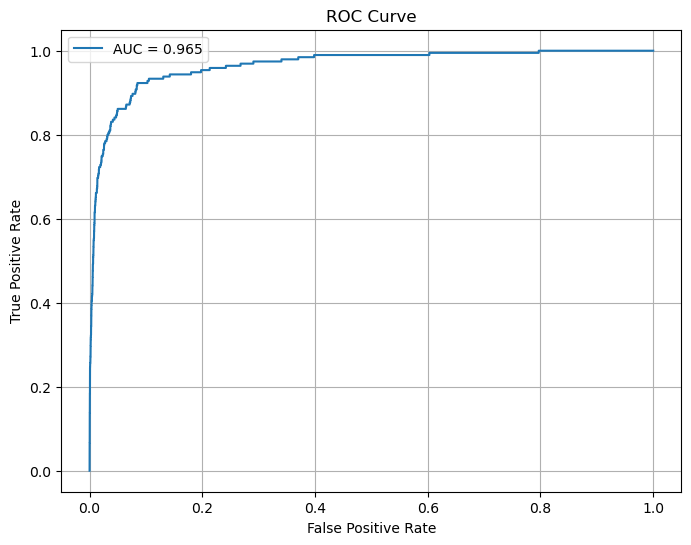

In [15]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
